# COGS 108 - Predicting Recipe Rating from Recipe Features

## Presentation

Video link: https://drive.google.com/file/d/1RqNI4C4EpS9zNG06yU5FO77B3n5VrTmQ/view?usp=sharing

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [ X ] NO - keep private

# Overview

Our group analyzed recipe data scraped from allrecipes.com in order to identify which features of a recipe are the strongest predictors of recipe star rating. We analyzed characteristics such as number of ingredients, number of steps in a recipe, recipe category, etc. We found that the number of ingredients and number of steps had the strongest correlation with overall star rating. A higher number of ingredients and lower number of steps is correlated with a higher star rating.

# Names

- Andrew Cheng
- Lauren Sidarto
- Isaac Otero
- Annie Huang

<a id='research_question'></a>
# Research Question

What features [time, number of ingredients, number of steps, etc.] of a dinner recipe are most predictive of its star rating?

<a id='background'></a>

## Background & Prior Work

We decided as a group to do an analysis related to food data; we felt that it's something that's very relevant and universally interesting. We've decided to utilize recipe data - something that's been done a lot before, for the same reason - since it has the potential to improve our abilities as cooks. This project will also allow us to use a good mix of data science and analysis techniques - web scraping, EDA, machine learning, and possibly sentiment analysis. 

There have been similar projects done before. Some notable ones:
1) **"Do Good Recipes Need Butter? Predicting User Ratings of Online Recipes"**[^yu]
- https://projet.liris.cnrs.fr/cwc/papers/cwc2013_submission_7.pdf
- Uses an SVM to predict recipe ratings based on recipe features, but also includes reviews. They achieved an accuracy of 62%; this paper notes that there's a bias in the distribution of stars/forks, with most ratings having around 3 or 4.

2) **Recipe rating prediction from text reviews**[^wang]
- https://www.eileenwang.work/predicting-customer-rating-from-recipes
- This one does text analysis on reviews as well. Something we wanted to potentially try doing! It also covers the differences between SVM and logistic regression, which'll help us figure out what to use.

Existing work differs in category (e.g. are they looking at all groups of recipes, including drinks and desserts?), and recipe website, and features considered. They also differ greatly in the type of machine learning model used, but many utilize SVMs.

[^yu]: Yu, Ning, et al. Do Good Recipes Need Butter? Predicting User Ratings of Online Recipes. https://projet.liris.cnrs.fr/cwc/papers/cwc2013_submission_7.pdf. 
[^wang]: Wang, Eileen. “Predicting Customer Rating from Recipes.” Eileen Wang, https://www.eileenwang.work/predicting-customer-rating-from-recipes. 

# Hypothesis


Hypothesis: We believe that factors that increase the complexity of the recipe such as longer recipe length, a higher number of ingredients, longer total cook time will lead to a lower rating. 

Reasoning: We believe that those who use recipes tend to be less experienced in the realm of cooking, therefore simpler recipes will produce higher ratings. 

# Dataset(s)

Dataset name: recipes.csv 

We utilized web scraping on http://allrecipes.com/ in order to build our dataset, so there is no link. The file name is recipes.csv. 

1386 observations after cleaning the dataset. 

This dataset contains recipe information from allrecipes.com. We included information on factors that we believed could have a significant influence on recipe star rating, such as number of ingredients, number of steps in a recipe, and the word count per step. 

We do not plan to use multiple datasets.

# Setup

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import seaborn as sns

Cells below contain the code used to scrape data

In [2]:
#constants
url = 'http://allrecipes.com/recipes/'
urls_to_scrape = []
categories = []

In [3]:
# collecting urls to scrape
ends = ['17057/everyday-cooking/more-meal-ideas/5-ingredients/main-dishes/',
        '15436/everyday-cooking/one-pot-meals/',
        '455/everyday-cooking/more-meal-ideas/30-minute-meals/',
        '94/soups-stews-and-chili/',
        '16099/everyday-cooking/comfort-food/',
        '80/main-dish/',
        '22992/everyday-cooking/sheet-pan-dinners/',
        '78/breakfast-and-brunch/',
        '17561/lunch/',
        '84/healthy-recipes/',
        '76/appetizers-and-snacks/',
        '96/salad/',
        '81/side-dish/',
        '156/bread/',
        '77/drinks/',
        '79/desserts/',
        '201/meat-and-poultry/chicken/',
        '200/meat-and-poultry/beef/',
        '205/meat-and-poultry/pork/',
        '93/seafood/',
        '1058/fruits-and-vegetables/fruits/',
        '95/pasta-and-noodles/',
        '1059/fruits-and-vegetables/vegetables/',
        '17562/dinner/',
       ]

cat = ['5-ingredient-main-dishes',
        'one-pot-meals',
        '30-minute-meals',
        'soups-stews-and-chili',
        'comfort-food',
        'main-dish',
        'sheet-pan-dinners',
        'breakfast-and-brunch',
        'lunch',
        'healthy-recipes',
        'appetizers-and-snacks',
        'salad',
        'side-dish',
        'bread',
        'drinks',
        'desserts',
        'chicken',
        'beef',
        'pork',
        'seafood',
        'fruits',
        'pasta-and-noodles',
        'vegetables',
        'dinner',
      ]


for e in ends:
    f = requests.get(url + e)
    soup = BeautifulSoup(f.text)

    try: 
        recipe_cards = soup.find('div', id="mntl-taxonomysc-article-list-group_1-0").findAll('a',href=True)
    except:
        recipe_cards = soup.find('div', id="tax-sc__recirc-list_1-0").findAll('a',href=True)

        
    temp = []
    for i in recipe_cards:
        temp.append(i['href'])
        urls_to_scrape.append(i['href'])
        categories.append(cat[ends.index(e)])

In [4]:
# save gathered urls to a csv. quality of life stuff
with open('urls_to_scrape.csv', 'w') as f:
    for x in urls_to_scrape:
        f.write(x+', ')

In [5]:
#read urls from csv
import csv
with open('urls_to_scrape.csv', newline='') as f:
    reader = csv.reader(f)
    urls_to_scrape = list(reader)
urls_to_scrape = urls_to_scrape[0][:-1] #the last line is a space so remove last url

In [6]:
def scrape_recipe(u): 
#scraping individual parts of a recipe
    #recipe title
    f = requests.get(u)
    soup = BeautifulSoup(f.text)
    info = {}
    
    try:
        info["recipe_title"] = soup.findAll('h1')[0].text.strip()

        #review, rating
        temp = soup.findAll('div', {'id':'mntl-recipe-review-bar_1-0'})[0].text.split()
        info["star_rating"] = float(temp[0])
        info["rating_count"] = temp[1]
        info["review_count"] = temp[2]

        #cook time info
        temp = soup.findAll('div', {'class':'mntl-recipe-details__item'})
        for a in temp:
            spl = a.text.strip().split(":")
            info[spl[0]] = spl[1].strip()

        #recipe writeup
        writeup = ''
        for b in soup.find('div', {'id':'mntl-recipe-intro__content_1-0'}).findAll('p'):
            writeup += b.text.strip() + ' '
        info["writeup"] = writeup

        #ingredients
        ingr = []
        for c in soup.findAll('li',{'class':'mntl-structured-ingredients__list-item'}):
            ingr.append(c.text.strip())
        info["ingr"] = ingr

        #steps
        steps = []
        for step in soup.find('div',{'id':'recipe__steps_1-0'}).findAll('p',{'class':'comp mntl-sc-block mntl-sc-block-html'}):
            steps.append(step.text.strip())
        info['steps'] = steps

        #nutrition info - we decided against this
#         x=soup.findAll('td', {'class':'mntl-nutrition-facts-summary__table-cell'})
#         for d in range(len(x)-1):
#             if (d%2 ==0):
#                 info[x[d+1].text] = x[d].text
#             d+=1

    except:
        #if the recipe can't be scraped (e.g. it's one of those top 10 articles, 
        #or an article with no rating, then print the link)
        print(u) 
    return info



In [7]:
#scrape all recipes
rows = []
c = 0
for u in urls_to_scrape: 
    if (c%50 == 0):
        print(c)
        
    temp = scrape_recipe(u)
    temp['category'] = categories[urls_to_scrape.index(u)]
    rows.append(temp)
    c+=1

df = pd.DataFrame.from_dict(rows)
df.head()
df.to_csv('recipes.csv')

0
https://www.allrecipes.com/recipe/215412/simple-deep-fried-turkey/
 https://www.allrecipes.com/recipe/240208/simple-baked-chicken-breasts/
 https://www.allrecipes.com/recipe/235158/worlds-best-honey-garlic-pork-chops/
 https://www.allrecipes.com/recipe/201934/pan-seared-tilapia/
 https://www.allrecipes.com/recipe/235153/easy-baked-chicken-thighs/
 https://www.allrecipes.com/recipe/8495/chicken-cordon-bleu-i/
 https://www.allrecipes.com/recipe/272293/fluffy-microwave-scrambled-eggs/
 https://www.allrecipes.com/recipe/23157/turkey-in-a-bag/
 https://www.allrecipes.com/recipe/244458/buttered-noodles/
 https://www.allrecipes.com/recipe/228498/slow-cooker-baby-back-ribs/
 https://www.allrecipes.com/recipe/97621/foolproof-rib-roast/
 https://www.allrecipes.com/recipe/25473/the-perfect-basic-burger/
 https://www.allrecipes.com/recipe/236432/brown-sugar-ham-steak/
 https://www.allrecipes.com/recipe/240522/easy-rib-eye-roast/
 https://www.allrecipes.com/recipe/14746/mushroom-pork-chops/
 http

 https://www.allrecipes.com/recipe/254232/authentic-thai-basil-chicken-very-easy-and-fast/
 https://www.allrecipes.com/recipe/24512/one-pot-tuna-casserole/
 https://www.allrecipes.com/recipe/276420/italian-sausage-and-gnocchi-skillet/
 https://www.allrecipes.com/recipe/212922/filipino-rice-arroz-valenciana/
 https://www.allrecipes.com/recipe/273255/italian-sausage-tortellini/
 https://www.allrecipes.com/recipe/11887/pesto-pasta/
 https://www.allrecipes.com/recipe/257938/spicy-thai-basil-chicken-pad-krapow-gai/
 https://www.allrecipes.com/recipe/72068/chicken-katsu/
 https://www.allrecipes.com/recipe/16311/simple-beef-stroganoff/
 https://www.allrecipes.com/recipe/8887/chicken-marsala/
 https://www.allrecipes.com/recipe/201934/pan-seared-tilapia/
 https://www.allrecipes.com/recipe/230857/easy-tuna-patties/
 https://www.allrecipes.com/recipe/132358/easy-garlic-lemon-scallops/
 https://www.allrecipes.com/recipe/15559/black-beans-and-rice/
 https://www.allrecipes.com/recipe/20225/creamed-c

 https://www.allrecipes.com/recipe/228650/easy-white-chicken-chili/
 https://www.allrecipes.com/recipe/62642/albondigas/
 https://www.allrecipes.com/recipe/217155/dry-onion-soup-mix/
 https://www.allrecipes.com/recipe/11679/homemade-mac-and-cheese/
 https://www.allrecipes.com/recipe/85337/microwave-baked-potato/
 https://www.allrecipes.com/recipe/24771/basic-mashed-potatoes/
 https://www.allrecipes.com/recipe/15925/creamy-au-gratin-potatoes/
 https://www.allrecipes.com/recipe/14685/slow-cooker-beef-stew-i/
 https://www.allrecipes.com/recipe/23600/worlds-best-lasagna/
 https://www.allrecipes.com/recipe/18379/best-green-bean-casserole/
 https://www.allrecipes.com/recipe/26317/chicken-pot-pie-ix/
 https://www.allrecipes.com/recipe/16354/easy-meatloaf/
 https://www.allrecipes.com/recipe/222000/spaghetti-aglio-e-olio/
250
 https://www.allrecipes.com/recipe/24264/sloppy-joes-ii/
 https://www.allrecipes.com/recipe/24332/ultimate-twice-baked-potatoes/
 https://www.allrecipes.com/recipe/23431/t

 https://www.allrecipes.com/gallery/the-best-sheet-pan-chicken-dinners/
 https://www.allrecipes.com/recipe/21009/sheet-pan-roasted-vegetables/
 https://www.allrecipes.com/recipe/255038/sheet-pan-chicken-fajitas/
 https://www.allrecipes.com/recipe/281435/sheet-pan-seafood-boil/
 https://www.allrecipes.com/recipe/268999/mediterranean-chicken-sheet-pan-dinner/
 https://www.allrecipes.com/recipe/268843/sheet-pan-shrimp-and-sausage-bake/
 https://www.allrecipes.com/recipe/262162/sheet-pan-salmon-and-bell-pepper-dinner/
 https://www.allrecipes.com/recipe/274966/sheet-pan-parmesan-chicken-and-veggies/
 https://www.allrecipes.com/recipe/242402/greek-lemon-chicken-and-potato-bake/
 https://www.allrecipes.com/gallery/healthy-sheet-pan-recipes-for-winter/
 https://www.allrecipes.com/recipe/269152/shrimp-and-vegetable-sheet-pan-dinner/
 https://www.allrecipes.com/recipe/283432/everything-salmon-sheet-pan-dinner/
 https://www.allrecipes.com/gallery/chicken-thigh-sheet-pan-dinner-recipes/
 https://w

 https://www.allrecipes.com/recipe/215184/blueberry-smoothie/
 https://www.allrecipes.com/recipe/260542/fluffy-flapjack-pancakes/
 https://www.allrecipes.com/recipe/230907/southern-fried-apples/
 https://www.allrecipes.com/recipe/51013/baked-oatmeal-ii/
 https://www.allrecipes.com/recipe/244251/no-cook-overnight-oatmeal/
 https://www.allrecipes.com/recipe/24530/buttermilk-pancakes-ii/
 https://www.allrecipes.com/recipe/246952/authentic-swedish-pancakes/
 https://www.allrecipes.com/recipe/52688/cinnamon-toast/
 https://www.allrecipes.com/recipe/277194/turkish-eggs-cilbir/
 https://www.allrecipes.com/recipe/14385/pasta-salad/
 https://www.allrecipes.com/recipe/13313/best-cream-of-broccoli-soup/
 https://www.allrecipes.com/recipe/16729/old-fashioned-potato-salad/
 https://www.allrecipes.com/recipe/23891/grilled-cheese-sandwich/
 https://www.allrecipes.com/recipe/39544/garden-fresh-tomato-soup/
 https://www.allrecipes.com/recipe/237984/marinated-cucumber-onion-and-tomato-salad/
 https://ww

 https://www.allrecipes.com/recipe/94055/best-bean-salad/
 https://www.allrecipes.com/recipe/144346/roasted-garlic-lemon-broccoli/
 https://www.allrecipes.com/recipe/35965/grandma-omas-pickled-okra/
 https://www.allrecipes.com/recipe/141314/the-best-vegetable-salad/
 https://www.allrecipes.com/recipe/229892/amazing-apple-butter/
600
 https://www.allrecipes.com/recipe/269881/saucy-sriracha-franks/
 https://www.allrecipes.com/recipe/267865/spooky-spider-halloween-hot-dogs/
 https://www.allrecipes.com/recipe/275252/grilled-halloumi-with-herbed-berry-salsa/
 https://www.allrecipes.com/recipe/8508134/air-fryer-veggie-sticks/
 https://www.allrecipes.com/recipe/8499611/roasted-raspberry-chipotle-mustard-cream-sauce/
 https://www.allrecipes.com/recipe/8499610/4-ingredient-bacon-ranch-cheese-ball/
 https://www.allrecipes.com/recipe/8499643/bacon-ranch-cheese-ball/
 https://www.allrecipes.com/recipe/215231/empanadas-beef-turnovers/
 https://www.allrecipes.com/recipe/15184/mouth-watering-stuffed-

 https://www.allrecipes.com/recipe/8509607/sweet-potato-wedges-with-rosemary-orange-brown-butter/
 https://www.allrecipes.com/recipe/8494902/tiktok-parmesan-crusted-roasted-potatoes/
 https://www.allrecipes.com/recipe/8499683/roasted-turnips/
 https://www.allrecipes.com/recipe/8500498/peach-bourbon-bbq-sauce/
 https://www.allrecipes.com/recipe/235663/sweet-potato-crunch/
 https://www.allrecipes.com/recipe/33385/best-spanish-rice/
 https://www.allrecipes.com/recipe/67952/roasted-brussels-sprouts/
 https://www.allrecipes.com/recipe/85337/microwave-baked-potato/
 https://www.allrecipes.com/recipe/24771/basic-mashed-potatoes/
 https://www.allrecipes.com/recipe/183835/quick-tartar-sauce/
 https://www.allrecipes.com/recipe/85389/gourmet-mushroom-risotto/
 https://www.allrecipes.com/recipe/15925/creamy-au-gratin-potatoes/
 https://www.allrecipes.com/recipe/158140/spaghetti-sauce-with-ground-beef/
 https://www.allrecipes.com/recipe/21261/yummy-sweet-potato-casserole/
 https://www.allrecipes.co

KeyboardInterrupt: 

In [8]:
#read urls
df = pd.read_csv('recipes.csv')
df.head()

,Unnamed: 0,recipe_title,star_rating,rating_count,review_count,Prep Time,Cook Time,Total Time,Servings,Yield,writeup,ingr,steps,category,Additional Time,Chill Time,Marinate Time,Rest Time
0,0,World's Best Honey Garlic Pork Chops,4.4,(645),475,10 mins,15 mins,25 mins,6.0,6 servings,When you're in need of a quick and easy dinner...,"['½ cup ketchup', '2 ⅔ tablespoons honey', '2 ...",['Preheat grill for medium heat and lightly oi...,5-ingredient-main-dishes,NaN,NaN,NaN,NaN
1,1,Pan-Seared Tilapia,4.7,(789),560,5 mins,10 mins,15 mins,4.0,4 fillets,If you're looking for an easy weeknight dinner...,"['4 (4 ounce) tilapia fillets', 'salt and grou...",['Rinse tilapia fillets in cold water and pat ...,5-ingredient-main-dishes,NaN,NaN,NaN,NaN
2,2,Easy Baked Chicken Thighs,4.2,(194),135,5 mins,30 mins,35 mins,4.0,NaN,NaN,"['4 chicken thighs', '4 teaspoons garlic powd...",['Preheat the oven to 375 degrees F (190 degre...,5-ingredient-main-dishes,NaN,NaN,NaN,NaN
3,3,Chicken Cordon Bleu,4.6,"(2,668)","1,849",10 mins,35 mins,45 mins,4.0,4 servings,Don't feel like going out tonight? You can eas...,"['nonstick cooking spray', '4 skinless, bonel...",['Preheat oven to 350 degrees F (175 degrees C...,5-ingredient-main-dishes,NaN,NaN,NaN,NaN
4,4,Fluffy Microwave Scrambled Eggs,4.7,(60),58,5 mins,5 mins,10 mins,2.0,2 servings,Your microwave is the key to irresistibly fluf...,"['4 eggs', '¼ cup milk', '⅛ teaspoon salt']",['Break the eggs into a microwave-proof mixing...,5-ingredient-main-dishes,NaN,NaN,NaN,NaN


# Data Cleaning

We started with data scraped from allrecipes.com. We removed all recipes that had a Null value for star rating, as we are primarily interested in the relationship between star rating and various other recipe characteristics. For any Null values in other columns, we imputed them with zeros or replaced them with the average for that category/column, depending on what made sense contextually. For example, Null review counts were replaced with zeros, while Null recipe cook times were replaced with the average cook time for the recipe category. We converted all numerical columns into int or float types and made sure all numbers utilized uniform units. For example, we converted all hours and days under cook time into minutes. We replaced the ingredient list and list of steps with the ingredient/step count, and added a column for word count per step.

In [9]:
#drop rows with null ratings
df = df[df['star_rating'].notna()]

#strip rating and review columns 
df['rating_count'] = df['rating_count'].str.slice(1,-1)
df['rating_count'] = df['rating_count'].str.replace(',','', regex = True)
df['review_count'] = df['review_count'].str.replace(',','', regex = True)

#turn rating and review columns into floats
replace = []
df = df.reset_index(drop = True)
for i in df.index:
    temp = df['ingr'][i]
    temp = temp.split('\'')[1::2]
    replace.append(len(temp))
for i in range(len(replace)):
    df.iloc[i, 11] = replace[i]
    
df = df.astype({'rating_count': 'float64', 'review_count': 'float64', 'ingr': 'int'})

In [10]:
#convert prep, cook, and total time columns into minutes 

#Time quantities in minutes
time_length = [1, 60, 60 * 24, 60 * 24 * 365]

# Param: Time is string or null (mins, hrs, days)
# Return: Total time in minutes
def time_to_int(time):
    #Check if not string will have to null input later
    if type(time) != str:
        return np.NaN
    
    #Gets the digits of all times in mins, hrs, days, etc.
    times = re.findall('\d+', time)[::-1]
    
    #Sums up each time and multiplies it by the number of mins in that time
    return sum([int(times[i]) * time_length[i] for i in range(len(times))])

#Converts prep time, cook time, and total time to int values
df['Prep Time'] = df['Prep Time'].apply(time_to_int)
df['Cook Time'] = df['Cook Time'].apply(time_to_int)
df['Total Time'] = df['Total Time'].apply(time_to_int)

In [11]:
#ftotal_steps_character and number_of_steps
df['steps'] = df['steps'].apply(lambda x: x.strip('[]').replace("\\"," ").replace("\"","").replace('\'',''))
df['number_of_steps'] = df['steps'].apply(lambda x: len(x.split(".,")))
   
#finding average_step_length 
df['average_step_len'] = df['steps'].apply(lambda x: len(x.replace(".,",",")))
df['average_step_len'] = df['average_step_len']/df['number_of_steps']

In [12]:
#turning writeup into length
df['writeup']=df['writeup'].fillna('')
df.writeup = df.writeup.apply(lambda x: len(x))

In [13]:
#drop unused columns: index, additional time, chill time, marinate time, rest time, yield
df = df.drop(columns=['Unnamed: 0','Additional Time','Chill Time','Marinate Time','Rest Time','Yield'], axis=1)

#rename columns to have consistent names
df = df.rename({"Prep Time":"prep_time","Cook Time":"cook_time","Total Time":"total_time", "Servings":"servings"},axis=1)

Null imputation

In [14]:
#all time columns have null values
df.isna().any()

recipe_title        False
star_rating         False
rating_count        False
review_count        False
prep_time            True
cook_time            True
total_time           True
servings            False
writeup             False
ingr                False
steps               False
category            False
number_of_steps     False
average_step_len    False
dtype: bool

In [15]:
#some of the null rows under "prep_time" column
df[df['prep_time'].isna()].head()

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
67,Scrambled Eggs in a Mug,4.5,43.0,32.0,NaN,5.0,5.0,1.0,0,3,Whisk egg in a microwave-safe mug. Whisk in mi...,one-pot-meals,2,96.500000
316,Brined and Roasted Whole Turkey,4.7,23.0,17.0,NaN,NaN,800.0,10.0,0,8,Overnight Brine: Combine Morton®Kosher Salt an...,main-dish,7,224.714286
458,Egg in a Hole,4.7,358.0,301.0,NaN,5.0,5.0,1.0,0,4,Melt bacon grease in a nonstick pan over low h...,breakfast-and-brunch,2,174.500000
710,Buffalo Chicken Wing Sauce,4.8,845.0,649.0,NaN,5.0,5.0,8.0,3244,7,"Combine hot sauce, butter, vinegar, Worcesters...",side-dish,1,290.000000
898,Soft Pumpkin Cookies,3.3,62.0,48.0,NaN,NaN,NaN,12.0,0,9,Preheat oven to 375 degrees F (190 degrees C)....,desserts,4,57.750000


We decided it would make sense to impute NaNs with the mean of the cook time under each category of food. For example, a NaN time for a drink will have the average cook time for a drink.

In [16]:
#Gets the mean time for each category for prep cook and total time
mean_time = df[['category','prep_time', 'cook_time', 'total_time']].groupby('category').transform('mean').round(2)
#Imputes the mean times of each category for the missing values
df = df.fillna(mean_time)
df.isna().any()

recipe_title        False
star_rating         False
rating_count        False
review_count        False
prep_time           False
cook_time           False
total_time          False
servings            False
writeup             False
ingr                False
steps               False
category            False
number_of_steps     False
average_step_len    False
dtype: bool

There are some duplicate recipes. We drop these by using df.duplicated():

In [17]:
df = df.loc[~df.duplicated(subset=None, keep='first')].reset_index(drop=True)

In [18]:
df.to_csv('recipes_clean.csv')

# Data Visualization

We look at the distribution of all the numerical variables. We note the left skew on the distribution of star_ratings - the fact that most recipes fall between 4 - 5 stars may affect our analysis. Additionally, all the time-related and ingredient related columns have a right skew.

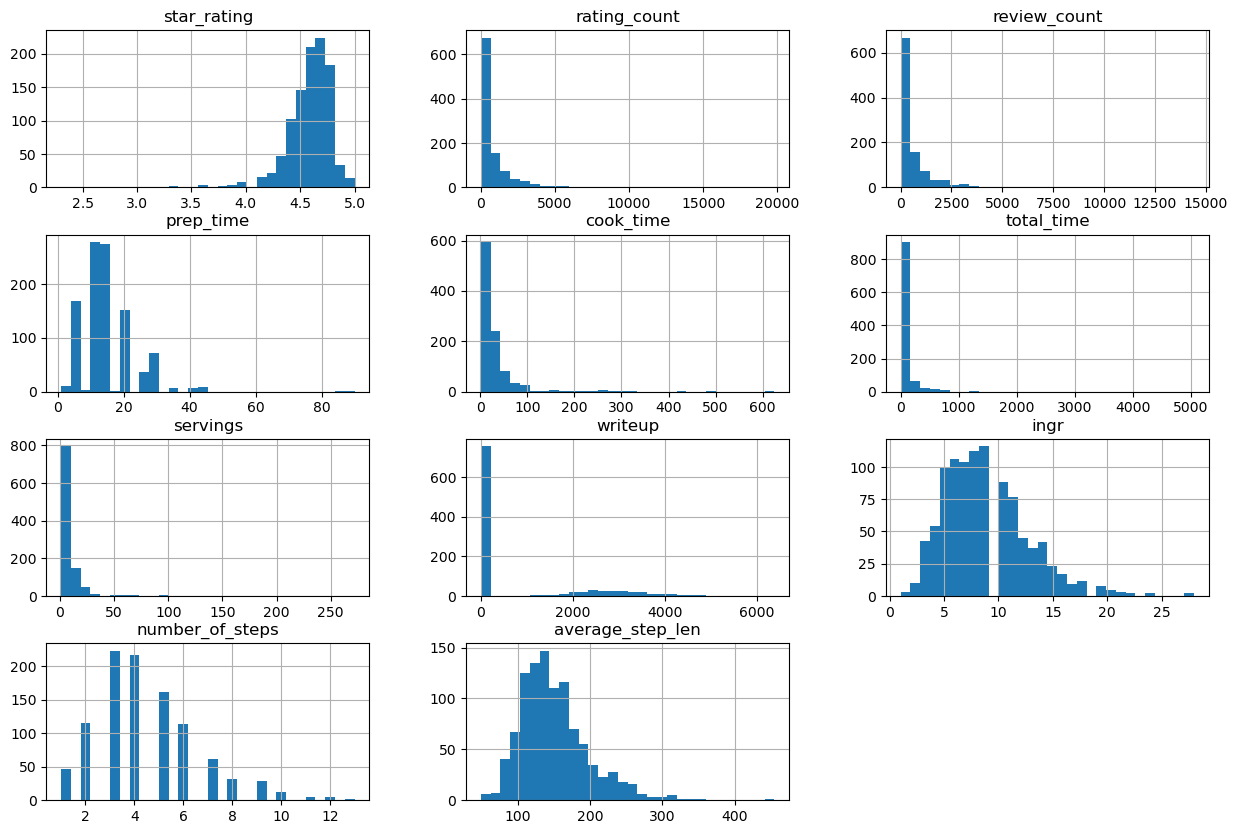

In [19]:
#checking distribution of all numberical variables
df.hist(bins=30,figsize=(15,10))
plt.show()

The histograms help to visualise outliers as well. Servings, ingredients, cook time, and rating have some values that are very high compared to the distribution. We looked into those to make sure our data made sense.

We looked into categorical distributions afterwards. There is a lack of recipes under the dinner category - this is because a lot of the duplicate recipes that were dropped likely belonged to multiple categories, but got dropped from the "dinner" during data cleaning. This is something we note for the future.

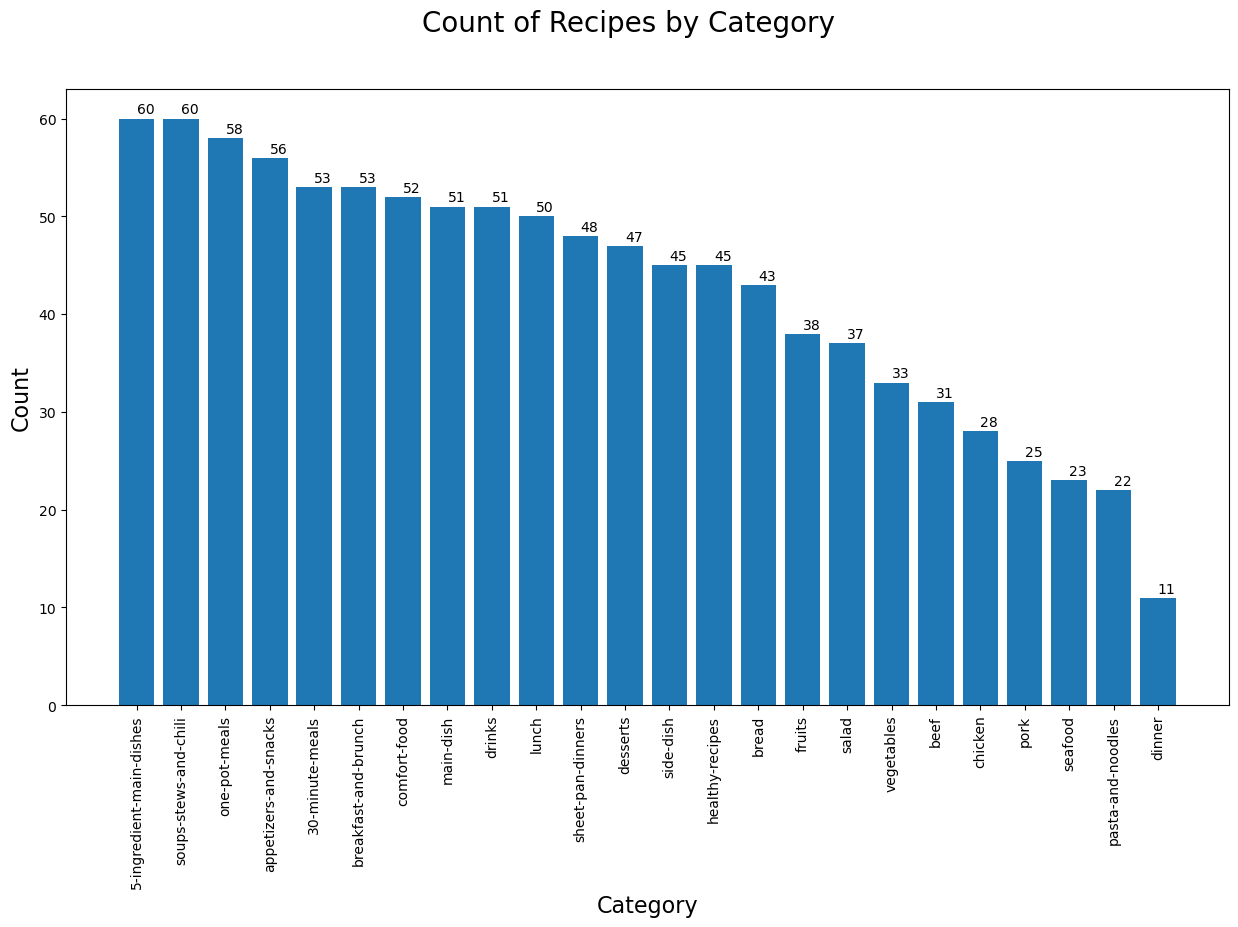

In [20]:
#Counts of categories
f1, ax = plt.subplots(figsize =(15, 8))
x= df['category'].value_counts().index
y=df['category'].value_counts()
ax.bar(x, y)
plt.xticks(rotation=90)
plt.suptitle('Count of Recipes by Category', fontsize=20)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Category', fontsize=16)

for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j+0.5))
    
plt.show()


We looked at the distribution on ratings within the two biggest categories, 5 Ingredient Main Dishes, and Soups, Stews, and Chillis. There is a right skew on the ratings of both datasets.

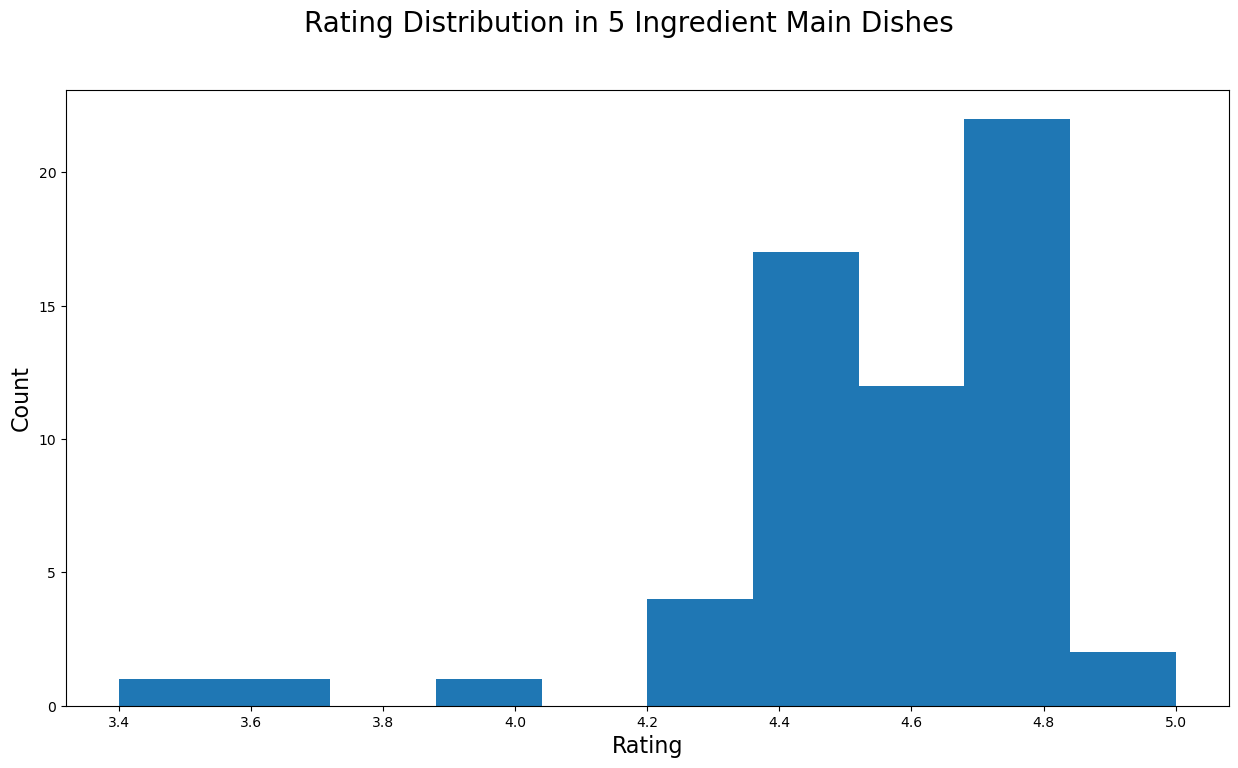

In [21]:
#Distribution of Category rating
f3, ax = plt.subplots(figsize =(15, 8))
ax.hist(df[df['category'] == '5-ingredient-main-dishes']['star_rating'])
plt.suptitle('Rating Distribution in 5 Ingredient Main Dishes', fontsize=20)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Rating', fontsize=16)
plt.show()

Text(0.5, 0, 'Rating')

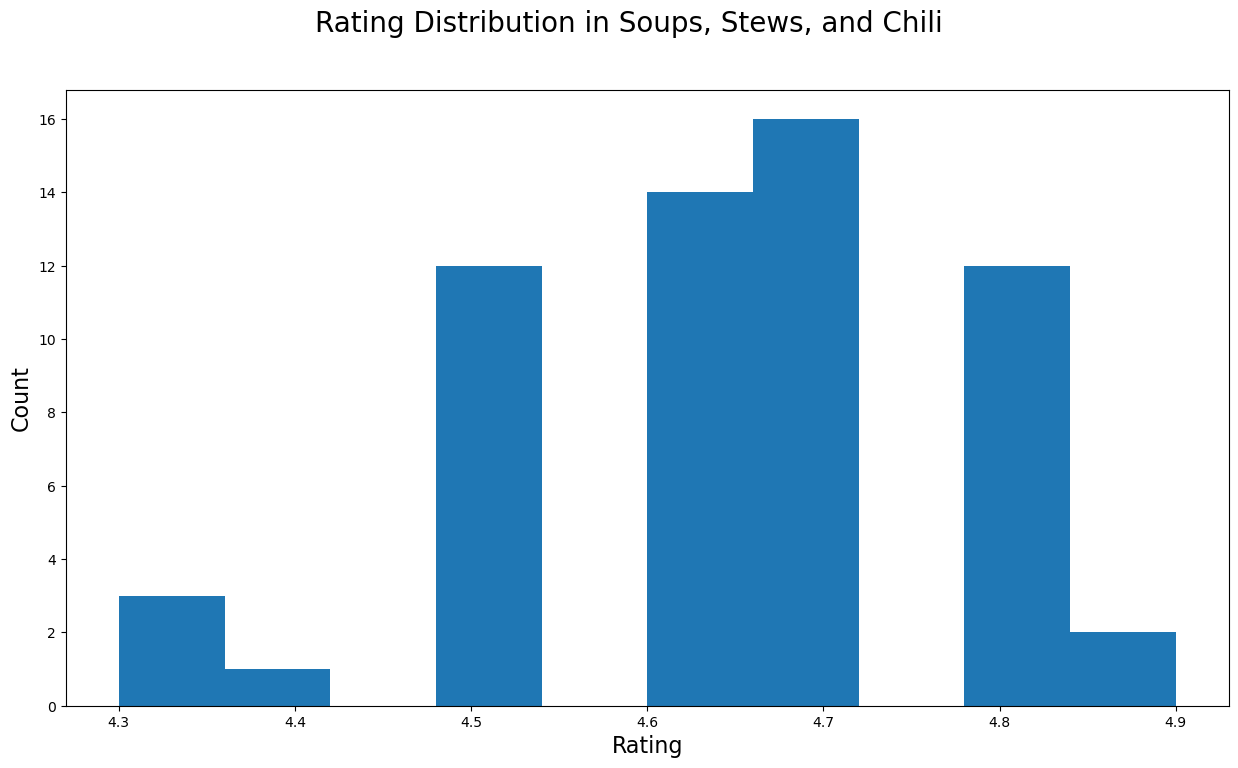

In [22]:
#Distribution of Soup rating
f4, ax = plt.subplots(figsize =(15, 8))
ax.hist(df[df['category'] == 'soups-stews-and-chili']['star_rating'])
plt.suptitle('Rating Distribution in Soups, Stews, and Chili', fontsize=20)
plt.ylabel('Count', fontsize=16)
plt.xlabel('Rating', fontsize=16)

# Data Analysis & Results

### EDA

We first read the saved data back into a dataframe. The dataset has 1020 recipes in it, after cleaning (including deduplication and removal of null rows).

In [23]:
#reading data in
df = pd.read_csv('recipes_clean.csv').drop(columns="Unnamed: 0",axis=1)
df.shape

(1020, 14)

In [24]:
df.loc[df.recipe_title == "Three Berry Pie"]

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
786,Three Berry Pie,4.6,478.0,391.0,45.0,45.0,2790.0,8.0,0,9,Make the crust: Combine flour and salt in a la...,desserts,8,243.0


In [25]:
#get basic descriptive statistics for the dataset
df.describe()

,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,number_of_steps,average_step_len
count,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000
mean,4.588039,893.648039,669.589216,14.652637,31.844588,93.617471,8.877451,755.692157,8.781373,4.408824,149.756137
std,0.231889,1771.111268,1306.444361,8.512378,48.921489,246.635284,12.325870,1348.200763,3.914223,2.098768,47.263181
min,2.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,48.333333
25%,4.500000,81.750000,65.000000,10.000000,10.000000,20.000000,4.000000,0.000000,6.000000,3.000000,117.083333
50%,4.600000,298.000000,239.000000,15.000000,20.000000,40.000000,6.000000,0.000000,8.000000,4.000000,140.410714
75%,4.700000,988.500000,748.250000,20.000000,34.482500,80.000000,10.000000,1609.250000,11.000000,6.000000,173.031250
max,5.000000,19800.000000,14420.000000,90.000000,625.000000,5055.000000,272.000000,6374.000000,28.000000,13.000000,455.000000


In [26]:
#outlier investigation - 250 servings?

df.iloc[df.servings.sort_values()[-1:].index]
#272 servings is a bulk salsa recipe. this makes sense

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
559,The Best Canning Salsa,4.3,60.0,54.0,25.0,35.0,815.0,272.0,2157,12,"Combine tomatoes, onions, vinegar, tomato past...",appetizers-and-snacks,8,176.5


In [27]:
#there's a recipe with a lot of ingredients, what is it?

df.iloc[df.ingr.sort_values()[-1:].index]
#after a manual check the chili recipe does actually have 28 ingredients.

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
199,Best Damn Chili,4.7,681.0,534.0,30.0,135.0,165.0,12.0,4169,28,Heat oil in a large pot over medium heat; cook...,soups-stews-and-chili,5,232.8


In [28]:
#there's a recipe with a long cook time, what is it?

df.iloc[df.cook_time.sort_values()[-1:].index]

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
528,Amazing Apple Butter,4.9,16.0,13.0,10.0,625.0,640.0,48.0,0,8,Combine apples and apple juice in a stockpot; ...,healthy-recipes,9,211.666667


In [29]:
#there's a recipe with a long total time, what is it?

df.iloc[df.total_time.sort_values()[-1:].index]

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
328,Dry Brine Turkey,4.8,18.0,15.0,15.0,150.0,5055.0,15.0,0,5,Pat turkey dry with paper towels. Season the i...,main-dish,9,162.555556


In [30]:
#what has the lowest rating?

df.iloc[df.star_rating.sort_values()[:1].index]
#after a manual check the banana chips recipe does actually have a 2.3 star rating.

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
939,Baked Banana Chips,2.3,9.0,9.0,10.0,2.0,135.0,2.0,0,2,Preheat the oven to 225 degrees F (110 degrees...,fruits,6,112.833333


In [31]:
#outlier check - long recipe writeup?

df.iloc[df.average_step_len.sort_values()[-1:].index]
#after a manual check the chili recipe does actually have 28 ingredients.

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
998,Raspberry Chipotle Sauce,4.6,40.0,35.0,10.0,30.0,1.0,8.0,0,9,Heat olive oil in a skillet over medium heat. ...,vegetables,1,455.0


At this point the data appeared to be sound - these recipes are definitely outliers, but they still make sense in the context of the recipe. Because of this, we decided to leave them in our dataset.

We then started looking into correlations.

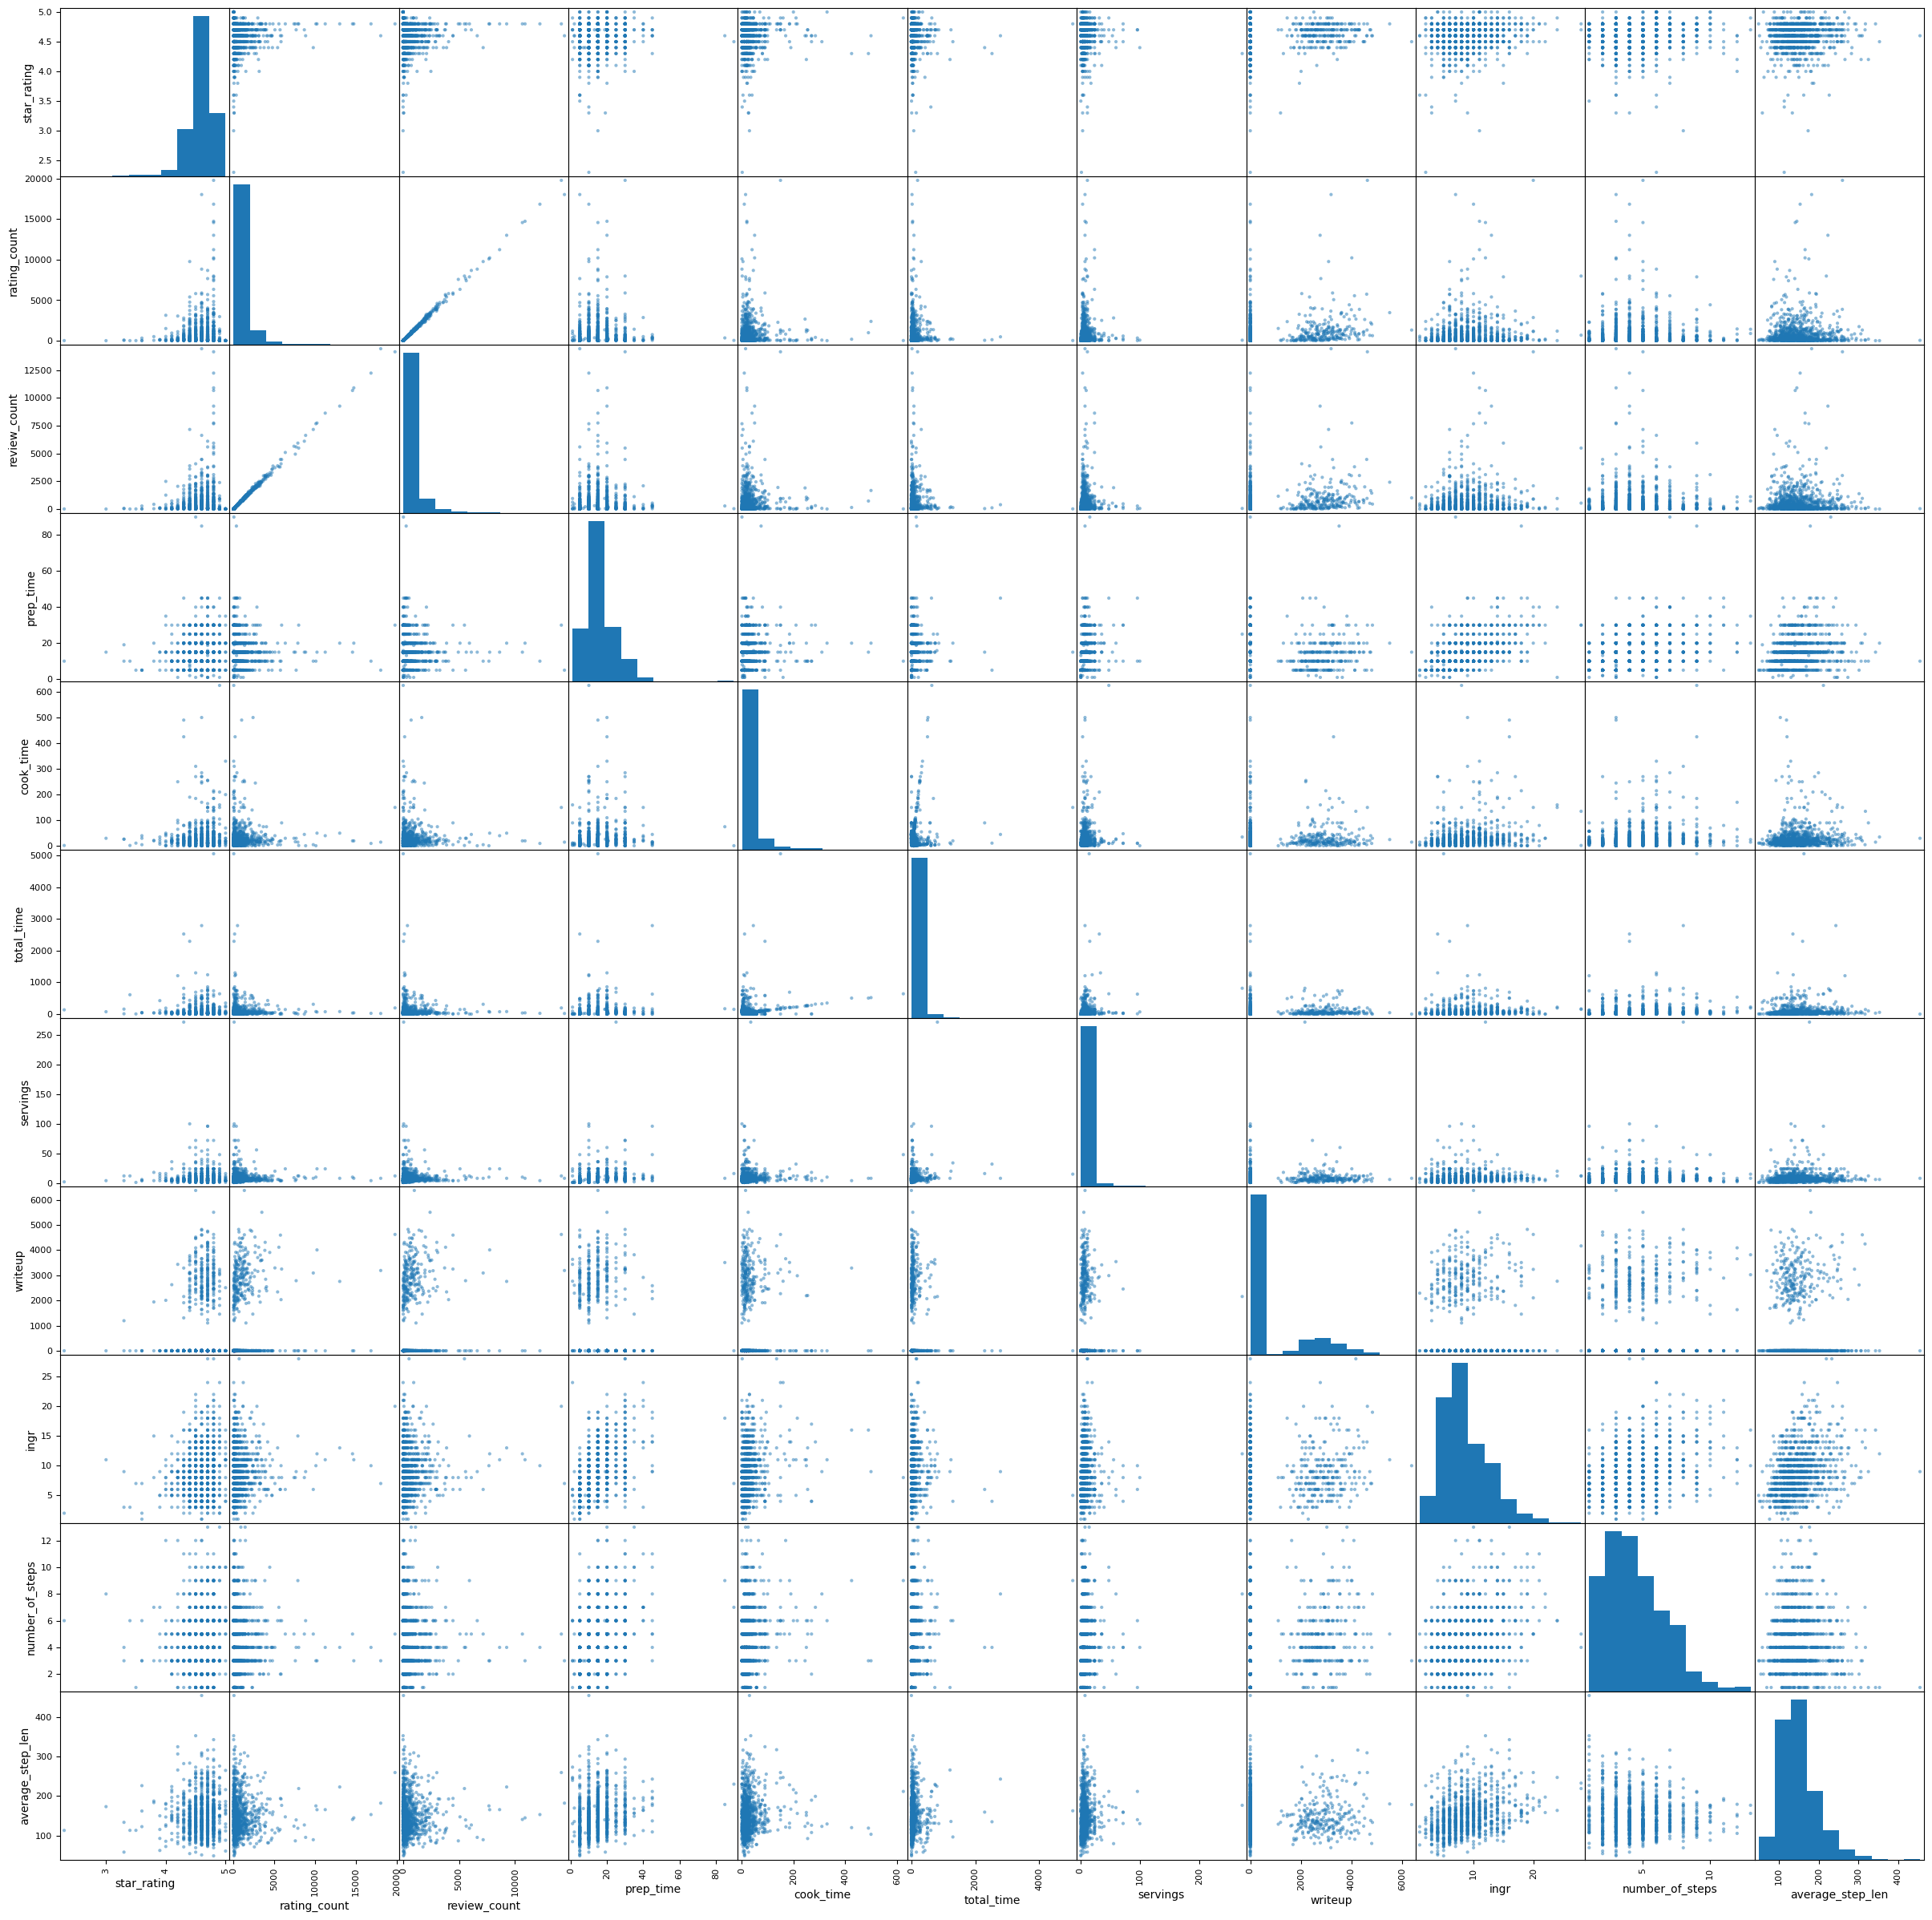

In [32]:
#looking at correlations
#Scatter matrix
fig = pd.plotting.scatter_matrix(frame = df, figsize = (30,30))

We then looked into some of the hypotheses we proposed. We hypothesized that there was a correlation between step number and recipe complexity, which might have an impact on rating:

Text(0.5, 0, 'Rating')

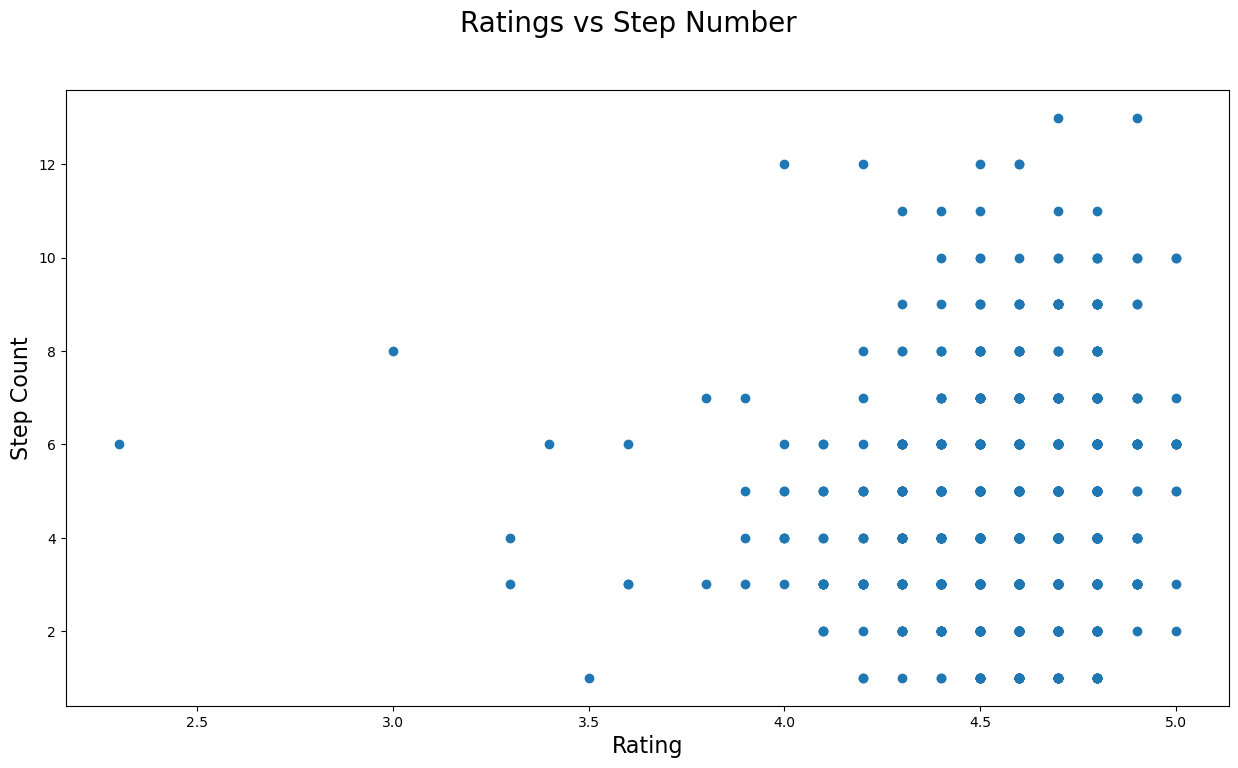

In [33]:
#Scatterplot rating vs num of step <- maybe how complex
f5, ax = plt.subplots(figsize =(15, 8))
ax.scatter(df['star_rating'],df['number_of_steps'])
plt.suptitle('Ratings vs Step Number', fontsize=20)
plt.ylabel('Step Count', fontsize=16)
plt.xlabel('Rating', fontsize=16)

Total time may also indicate recipe complexity, which may have an impact on rating:

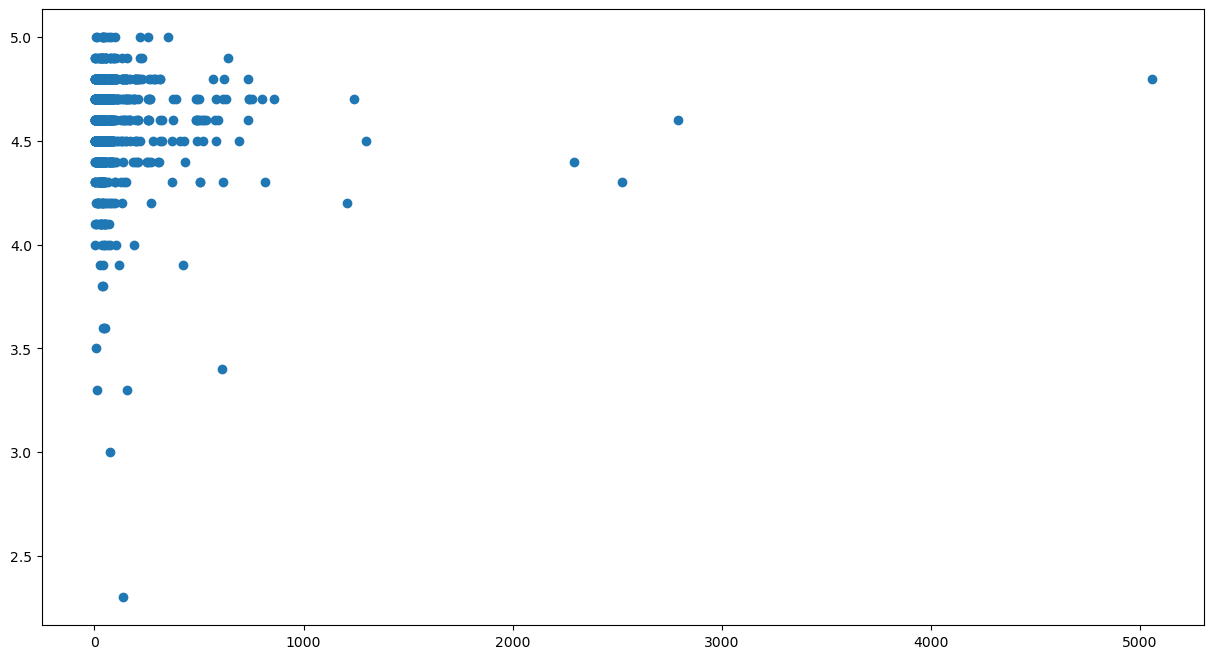

In [34]:
#Scatterplot rating vs total time <- maybe how complex
f6, ax = plt.subplots(figsize =(15, 8))
ax.scatter(df['total_time'],df['star_rating'])

There seems to be no strong correlation between time and rating, but there may be one between step number and rating. We worked to confirm this further with linear regression.

                            OLS Regression Results                            
Dep. Variable:            star_rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.887
Date:                Fri, 02 Dec 2022   Prob (F-statistic):             0.0489
Time:                        16:44:13   Log-Likelihood:                 45.854
No. Observations:                1020   AIC:                            -87.71
Df Residuals:                    1018   BIC:                            -77.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.5580      0.017    2

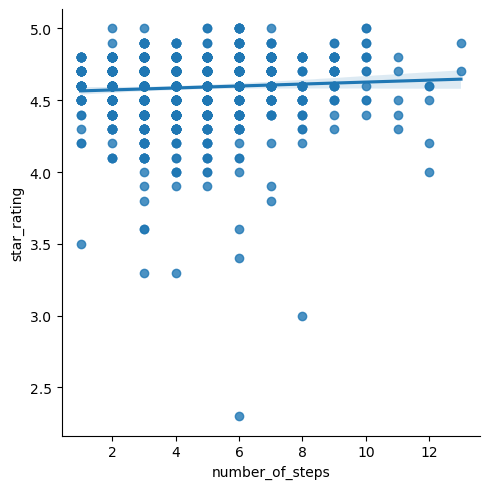

In [35]:
x, y = patsy.dmatrices('star_rating ~ number_of_steps', df)
mod_1 = sm.OLS(x, y)
res_1 = mod_1.fit()
print (res_1.summary())
sns.lmplot(data = df, y = 'star_rating', x = 'number_of_steps')


This analysis gives us a p-value of 0.049. With a cutoff of p=0.05, we accept that there may be a correlation between step number and star rating. This indicates that step number, and by extension the other step-related columns, may be good predictors of star rating. This is helpful information as we move into creating a model.

## Training a model

We proceeded to create a model to determine which of our features are most predictive of star rating. We decided to use a simple linear regression model with all the features, and then check the regression coefficients ($w_0...w_n $ below) to see which feature is most impactful.

$$rating = w_0*feature_0 + w_1*feature_1 + ... + w_n*feature_n$$




In [36]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

We split the data into a train and test set, with 70% of the data going to the training dataset, and 30% going to the test set.

In [37]:
#trying linear regression to figure out which features are most predictive of y
#splitting the data
Y = df['star_rating']
X = df.select_dtypes(include=np.number).drop(['star_rating'],axis=1)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.3)

The following cell fits a linear regression model, and predicts ratings on the test data:

In [38]:
#training linear regression
mod1 = LinearRegression().fit(train_X, train_Y)
preds = mod1.predict(test_X)

We then view the predictions by comparing them with the actual Y on the test data:

In [39]:
#view predictions vs actual, on the test data
results = pd.DataFrame({"pred":preds, "actual":test_Y})
results.head()

,pred,actual
967,4.622340,4.5
476,4.625763,4.4
269,4.607200,4.7
514,4.617239,4.4
783,4.610611,4.7


The model is quantified by the mean squared error (MSE), which is a good metric for linear regression models.

In [40]:
#mean squared error - quantify how good the predictions are
mod1_mse = mean_squared_error(test_Y, preds)
mod1_mse

0.06878557577027909

We then view the coefficients of the model to see which features are most impactful:

In [41]:
#view features and their model coefficients
feats = train_X.columns.to_list()
for i,v in enumerate(mod1.coef_):
    print("feature: ", feats[i], ", score: ",v)

feature:  rating_count , score:  0.00010819493998179844
feature:  review_count , score:  -0.00013444136621737924
feature:  prep_time , score:  -0.0009034925894568115
feature:  cook_time , score:  0.0001117572743614674
feature:  total_time , score:  -9.819915651859597e-06
feature:  servings , score:  0.001407534009687334
feature:  writeup , score:  1.837198523219242e-05
feature:  ingr , score:  0.010851185349439373
feature:  number_of_steps , score:  0.0008553817665767118
feature:  average_step_len , score:  -0.00011238042499023192


We found that number of ingredients and number of steps are the two most predictive features of star rating. We trained another LinearRegeression model with just these two columns to see if the MSEs were comparable:

In [42]:
#Model using the most impactful features Ingr, number of steps
#splitting the data
Y = df['star_rating']
X_ingr_step = df[['ingr','number_of_steps']]
train_X_ingr_step, test_X_ingr_step, train_Y_ingr_step, test_Y_ingr_step = train_test_split(X_ingr_step, Y, test_size=0.3)

#training linear regression
mod2 = LinearRegression().fit(train_X_ingr_step, train_Y)
preds2 = mod2.predict(test_X_ingr_step)
#view predictions vs actual, on the test data
results2 = pd.DataFrame({"pred":preds2, "actual":test_Y})
results2
#mean squared error - quantify how good the predictions are
mod2_mse = mean_squared_error(test_Y, preds2)
mod2_mse

0.06852996200668202

In [43]:
mod1_mse - mod2_mse

0.0002556137635970762

The models seem to be comparable. 

We then were interested to see if this differs for recipes in each category. We repeated the same steps as above, but with the data filtered to certain categories.

<b>Main dishes</b>

In [44]:
#Models based on category soups and main dish

#Main dish
df_main =  df[df['category'] == '5-ingredient-main-dishes']

#trying linear regression to figure out which features are most predictive of y
#splitting the data
Y_main = df_main['star_rating']
X_main = df_main.select_dtypes(include=np.number).drop(['star_rating'],axis=1)
train_X_main, test_X_main, train_Y_main, test_Y_main = train_test_split(X_main, Y_main, test_size=0.3)
 
#training linear regression
modl_main = LinearRegression().fit(train_X_main, train_Y_main)
preds_main = modl_main.predict(test_X_main)
mod1_mse_main = mean_squared_error(test_Y_main, preds_main)
mod1_mse_main

0.16716882605710226

In [45]:
#view features and their model coefficients
feats = train_X_main.columns.to_list()
for i,v in enumerate(modl_main.coef_):
    print("feature: ", feats[i], ", score: ",round(v,3))

feature:  rating_count , score:  0.001
feature:  review_count , score:  -0.001
feature:  prep_time , score:  0.022
feature:  cook_time , score:  0.002
feature:  total_time , score:  -0.001
feature:  servings , score:  -0.033
feature:  writeup , score:  0.0
feature:  ingr , score:  -0.033
feature:  number_of_steps , score:  0.022
feature:  average_step_len , score:  0.001


The same analysis, but on <b>Soup Dishes</b>:

In [46]:
#Soup dish
df_soup =  df[df['category'] == 'soups-stews-and-chili']

#trying linear regression to figure out which features are most predictive of y
#splitting the data
Y_soup = df_soup['star_rating']
X_soup = df_soup.select_dtypes(include=np.number).drop(['star_rating'],axis=1)
train_X_soup, test_X_soup, train_Y_soup, test_Y_soup = train_test_split(X_soup, Y_soup, test_size=0.3)
 
#training linear regression
modl_soup = LinearRegression().fit(train_X_soup, train_Y_soup)
preds_soup = modl_soup.predict(test_X_soup)
mod1_mse_soup = mean_squared_error(test_Y_soup, preds_soup)
mod1_mse_soup

0.03898611844857271

In [47]:
#view features and their model coefficients
feats = train_X_soup.columns.to_list()
for i,v in enumerate(modl_soup.coef_):
    print("feature: ", feats[i], ", score: ",round(v,3))

feature:  rating_count , score:  -0.0
feature:  review_count , score:  0.0
feature:  prep_time , score:  -0.006
feature:  cook_time , score:  0.0
feature:  total_time , score:  -0.0
feature:  servings , score:  -0.012
feature:  writeup , score:  -0.0
feature:  ingr , score:  0.02
feature:  number_of_steps , score:  -0.002
feature:  average_step_len , score:  0.0


It seems that there are no significant changes to the weights of features within different mean categories. Notably, number_of_steps is consistently higher relative to the others.

# Testing the Model

Let's compare our model to other famous websites! We will use a high rated chicken recipe from [Tasty](https://tasty.co/recipe/american-buttermilk-fried-chicken) and a healthy low rated recipe from [Eat this not that](https://www.eatthis.com/a-healthier-orange-chicken-recipe/) 

In [48]:
df.columns

Index(['recipe_title', 'star_rating', 'rating_count', 'review_count',
       'prep_time', 'cook_time', 'total_time', 'servings', 'writeup', 'ingr',
       'steps', 'category', 'number_of_steps', 'average_step_len'],
      dtype='object')

In [49]:
tasty = ['American Buttermilk Fried Chicken', 4.8, 1627, 257, 5, 35, 40, 3, 0, 15, '708','5-ingredient-main-dishes', 6, 118]
tasty = pd.DataFrame(dict(zip(df.columns, tasty)), index = [0])
tasty

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
0,American Buttermilk Fried Chicken,4.8,1627,257,5,35,40,3,0,15,708,5-ingredient-main-dishes,6,118


In [50]:
eat = ['A Healthier Orange Chicken Recipe', 2.8, 723, 723, 10, 7, 17, 4, 436, 17, '530','5-ingredient-main-dishes', 2, 265]
eat = pd.DataFrame(dict(zip(df.columns, eat)), index = [0])
eat

,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
0,A Healthier Orange Chicken Recipe,2.8,723,723,10,7,17,4,436,17,530,5-ingredient-main-dishes,2,265


In [51]:
#Tasty
X_tasty = tasty.select_dtypes(include=np.number).drop(['star_rating'],axis=1)
print(tasty['recipe_title'][0])
print('pred: ' + str(mod1.predict(X_tasty)[0]))
print('actual: ' + str(tasty['star_rating'][0]))

American Buttermilk Fried Chicken
pred: 4.781300891038388
actual: 4.8


In [52]:
#Eat
X_eat = eat.select_dtypes(include=np.number).drop(['star_rating'],axis=1)
print(eat['recipe_title'][0])
print('pred: ' + str(mod1.predict(X_eat)[0]))
print('actual: ' + str(eat['star_rating'][0]))

A Healthier Orange Chicken Recipe
pred: 4.624600820798062
actual: 2.8


As you can see our model favors more ingredients and less steps despite the Tasty recipe having a much higher star rating.

For fun we will test our model with Annie's favorite cheesecake [recipe](https://sugarspunrun.com/best-cheesecake-recipe/):

In [53]:
#Annie's favorite cheesecake recipe!!
cake = ['The Best Cheesecake Recipe', 4.97, 1578, 4614, 20, 75, 95, 12, 4752, 10, '1912','5-ingredient-main-dishes', 8, 239]
cake = pd.DataFrame(dict(zip(df.columns, cake)), index = [0])
cake


,recipe_title,star_rating,rating_count,review_count,prep_time,cook_time,total_time,servings,writeup,ingr,steps,category,number_of_steps,average_step_len
0,The Best Cheesecake Recipe,4.97,1578,4614,20,75,95,12,4752,10,1912,5-ingredient-main-dishes,8,239


In [54]:
#Cake
X = cake.select_dtypes(include=np.number).drop(['star_rating'],axis=1)
print(cake['recipe_title'][0])
print('pred: ' + str(mod1.predict(X)[0]))
print('actual: ' + str(cake['star_rating'][0]))

The Best Cheesecake Recipe
pred: 4.214444398414615
actual: 4.97


Wow our model is pretty accurate with Annie's recipe :)

# Ethics & Privacy

There could be ethical concerns related to our data collection process because we will be scraping data from the internet, so participants will not be informed that their reviews and recipes are being used in our analysis. However, because this information is publicly available, we are not concerned with possible privacy violations. We will only be collecting non-intrusive information such as recipe ingredients, ratings, and word count. Data on recipe authors will be collected, but we will not be using it in our analysis. 

Possible biases exist in our dataset because we are only collecting recipe data from one website. This website is an American recipe website, so there will be a lack of representation of food from other cultures, and the ratings of recipes may be skewed to represent Eurocentric opinions. The data also represents a biased population, as we are only collecting ratings from people who have reliable internet access, are able to cook for themselves, and who choose to utilize allrecipes.com. We will not be altering the dataset we use, but we will take these biases into consideration while writing our analysis and drawing conclusions. We recognize that the ratings we are using are only representative of a small population, and do not necessarily reflect a universal rating system.


# Conclusion & Discussion

Our analysis finds that number of ingredients and number of steps are the most predictive features of star rating. Number of ingredients has a positive sign, indicating that the more ingredients a recipe has, the higher rating. This goes against our initial hypothesis, but might suggest that flavor complexity is an important feature of a recipe - we can see how this might make sense. Number of steps has a negative sign, indicating that the less steps, the higher rating. This is consistent with our hypothesis that execution complexity will reduce the rating of a recipe; easier recipes will have higher ratings, because they're more accessible to more people.

We note, importantly, that all of the regression coefficients are very close to 0 - none of the features are necessarily extremely predictive of rating. Other limitations on this conclusion stem from the bias in data. One might be the skew in ratings; most recipes have are around 3-4.5 stars. Another might be the way we, or AllRecipes, classify categories - the imbalance in classes impacted our data when we imputed null values of cook and prep time with category means. The model results show that time related columns have little impact on rating, however.

# Team Contributions

All group members met up weekly to work on the project checkpoints together. We divided the project proposal into four parts, with each group member writing one part. Lauren built the web scraper and created the initial data set, after which we split data cleaning between the remaining three group members. We all performed individual EDA on the data, and then combined what we thought were the most useful aspects of each analysis. Lauren and Andrew performed data analysis using sklearn, Annie wrote the final writeup, and Annie completed the presentation for the video.